In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
import time
import re
from itertools import chain
from transformers import pipeline
import ast

In [2]:
EMBEDDINGS_LABEL = "label_embedding"
THRESHOLD = 0.7
SAMPLES_LEN = 300
TOP_MATCHES = 5

In [3]:
import requests
def get_esco_df(url):
  response = requests.get(url)
  with open("esco_embeddings.npz", "wb") as file:
    file.write(response.content)
  data = np.load("esco_embeddings.npz", allow_pickle=True)
  return pd.DataFrame({
      "label": data["label"],
      "broader": data["broader"],
      "embedding": list(data["embedding"]),
      "label_embedding": list(data["label_embedding"]),
      "cleaned_embedding": list(data["cleaned_embedding"]),
      "cleaned_label_embedding": list(data["cleaned_label_embedding"]),
  })

In [4]:
from sklearn.model_selection import train_test_split

merged_dataset_df = pd.read_csv("hf://datasets/Boanerges/multisource-esco-set/merged_dataset.csv")
train_df, test_df = train_test_split(merged_dataset_df, test_size=0.3, random_state=42)
test_df = test_df[test_df['sentence_type'] == "explicit"]
test_df = test_df[test_df['extract'] == "job"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# https://www.kaggle.com/code/mangleshkumar/job-recommendation-system
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Lemmatize and remove stopwords
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
from collections import Counter

def get_df_samples(df, samples_len=SAMPLES_LEN):
    return df.sample(n=samples_len, random_state=42)

def print_results(df):
  matched = df[df.apply(lambda row: row['preferredLabel'] in row['esco'], axis=1)]

  def count_same_broader(skill_labels):
    if not skill_labels: return "0/0"
    broader_categories = [esco_df[esco_df["label"] == skill]["broader"].values[0] for skill in skill_labels if skill in esco_df["label"].values]

    if not broader_categories: return "0/0"

    most_common_broader = max(set(broader_categories), key=broader_categories.count)
    same_broader_count = broader_categories.count(most_common_broader)

    return f"{same_broader_count}/{len(skill_labels)}"

  def score_group(score_list):
    if not score_list: return "0%"
    max_score = max(score_list) * 100
    return f"{int(max_score // 5) * 5}%"

  matched = matched.copy()  # Ensure it’s a copy, not a view
  matched['same_broader_count'] = matched['esco'].apply(count_same_broader)
  matched['score_group'] = matched['score'].apply(score_group)

  broader_counts = Counter(matched['same_broader_count'])
  score_counts = Counter(matched['score_group'])

  print(f"{len(matched)} / {len(df)} ({len(matched) / len(df) * 100:.2f}%), ({df['esco'].apply(len).sum()})")

  # print("Same broader category counts per row:")
  # for key, value in sorted(broader_counts.items(), key=lambda x: x[0], reverse=True):
  #       print(f"{value} rows have {key} broader")

  # print("\nScore distribution for matched skills (rounded to 5%):")
  # for key, value in sorted(score_counts.items(), key=lambda x: int(x[0].replace('%', '')), reverse=True):
  #   print(f"{value} rows have scores above {key}")

In [7]:
test_samples = get_df_samples(test_df)

In [8]:
model = SentenceTransformer('abd1987/esco-context-skill-extraction')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/abd1987_esco_context_skill_extraction.npz")

modules.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/305 [00:00<?, ?B/s]

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def find_esco_skill(input_embeddings, embeddings, threshold=THRESHOLD):
    all_skills = []
    all_scores = []
    matched_skills = []

    for embedding in input_embeddings:
      # Compute cosine similarity with all ESCO embeddings
      similarities = cosine_similarity([embedding], embeddings)[0]
      above_threshold_indices = np.where(similarities >= threshold)[0]
      matched_skills.extend([
          (esco_df.iloc[i]['label'], similarities[i]) for i in above_threshold_indices
      ])

    # Sort results by similarity score
    matched_skills.sort(key=lambda x: x[1], reverse=True)
    matched_skills = matched_skills[:TOP_MATCHES]
    all_scores.extend([score for skill, score in matched_skills if skill not in all_skills])
    all_skills.extend([skill for skill, score in matched_skills if skill not in all_skills])

    return pd.Series([all_skills, all_scores])

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def get_embeddings(x, model, tokenizer=None):
    return model.encode(x, normalize_embeddings=True, device=device)

def get_jobbert_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

In [11]:
res_cols = ["Precision", "Recall", "F1-score", "Threshold", "Skills-count", "Matched", "Accuracy", "Avg-Score"]
res_df = pd.DataFrame(columns=res_cols)

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(df, esco_df):
    multibinarizer = MultiLabelBinarizer(classes=list(set(esco_df["label"].explode())))

    y_true = list(df["preferredLabel"].apply(lambda x: [x]).tolist())  # Convert single label into a list
    y_pred = list(df["esco"].tolist())

    matched = len(df[df.apply(lambda row: row['preferredLabel'] in row['esco'], axis=1)])
    matched_text = f"{matched} / {SAMPLES_LEN} ({matched / SAMPLES_LEN * 100:.2f}%)"

    matched_scores = df.apply(lambda row: sum(row['score'][i] for i, skill in enumerate(row['esco']) if skill == row['preferredLabel']), axis=1)
    all_scores = df['score'].apply(sum)

    y_true = multibinarizer.fit(y_true).transform(y_true)
    y_pred = multibinarizer.transform(y_pred)

    precision = precision_score(y_true, y_pred, average="samples", zero_division=0)
    recall = recall_score(y_true, y_pred, average="samples", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="samples", zero_division=0)
    """
        TP = sum(1 for pred in predicted_labels if pred == true_label)
        precision = TP / len(predicted_labels) if predicted_labels else 0
        recall = TP / 1  # Only one correct label (preferredLabel)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    """
    avg_score = matched_scores.sum() / all_scores.sum() if all_scores.sum() > 0 else 0

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Threshold": THRESHOLD,
        "Skills-count": df['esco'].apply(len).sum(),
        "Matched": f"{matched} / {SAMPLES_LEN}",
        "Accuracy": matched / SAMPLES_LEN,
        "Avg-Score": f"{avg_score:.4f}"
    }

In [13]:
embeddings_list = np.stack(esco_df[EMBEDDINGS_LABEL].values)

# Examples

### Vector Similarity

In [14]:
simple_df = get_df_samples(test_df)
simple_df[['esco', 'score']] = simple_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(x, model)],
            embeddings_list,
            THRESHOLD
        )
    )
)

res_df.loc["Vector Similarity"] = calculate_metrics(simple_df, esco_df)
print_results(simple_df)

212 / 300 (70.67%), (741)


## Split

#### Split Methods

In [15]:
def split_text_statements(text):
    """Splits a text into smaller statements."""
    if not isinstance(text, str) or not text.strip(): return []  # Return empty list for invalid inputs
    return [s.strip() for s in re.split(r"[\r\n\t.,;]| and | or ", text) if s] + [text]

#### Split Example

In [16]:
split_df = get_df_samples(test_df)
split_df[['esco', 'score']] = split_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(y, model) for y in split_text_statements(x)],
            embeddings_list,
            THRESHOLD
        )
    )
)

res_df.loc["Split"] = calculate_metrics(split_df, esco_df)
print_results(split_df)

210 / 300 (70.00%), (1135)


## NER

##### NER Methods

In [17]:
skill_classifier = pipeline(model="jjzha/escoxlmr_skill_extraction", aggregation_strategy="simple")
knowledge_classifier = pipeline(model="jjzha/escoxlmr_knowledge_extraction", aggregation_strategy="simple")

config.json:   0%|          | 0.00/991 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/463 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/991 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/463 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Device set to use cpu


In [18]:
def aggregate_span(results):
    new_results = []
    current_result = results[0]

    for result in results[1:]:
        if result["start"] == current_result["end"] + 1:
            current_result["word"] += " " + result["word"]
            current_result["end"] = result["end"]
        else:
            new_results.append(current_result)
            current_result = result

    new_results.append(current_result)
    return new_results

def ner(text):
    output_skills = skill_classifier(text)
    for result in output_skills:
        if result.get("entity_group"):
            result["entity"] = "Skill"
            del result["entity_group"]

    output_knowledge = knowledge_classifier(text)
    for result in output_knowledge:
        if result.get("entity_group"):
            result["entity"] = "Knowledge"
            del result["entity_group"]

    if len(output_skills) > 0: output_skills = aggregate_span(output_skills)
    if len(output_knowledge) > 0: output_knowledge = aggregate_span(output_knowledge)
    res = [*output_skills, *output_knowledge]
    return [d["word"] for d in res] + [text]

#### NER Example

In [19]:
ner_df = get_df_samples(test_df)
ner_df[['esco', 'score']] = ner_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(y, model) for y in ner(x)],
            embeddings_list,
            THRESHOLD
        )
    )
)

res_df.loc["NER"] = calculate_metrics(ner_df, esco_df)
print_results(ner_df)

214 / 300 (71.33%), (1135)


## LLM

#### LLM Methods

In [20]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
model_path = "abd1987/esco-flan-t5-large"
llm_model = T5ForConditionalGeneration.from_pretrained(model_path)
llm_tokenizer = T5Tokenizer.from_pretrained(model_path)

config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/21.8k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.67k [00:00<?, ?B/s]

In [21]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
model_path = "google/flan-t5-large"
llm_model_large = T5ForConditionalGeneration.from_pretrained(model_path)
llm_tokenizer_large = T5Tokenizer.from_pretrained(model_path)

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [22]:
def start_prompt(prompt, llm_model, llm_tokenizer):
  inputs = llm_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
  with torch.no_grad(): # No training, just predictions => Disables gradient tracking (Faster & Memory Efficient)
      outputs = llm_model.generate(inputs.input_ids, max_length=512)
  return llm_tokenizer.decode(outputs[0], skip_special_tokens=True)

def extract_skills(text, llm_model, llm_tokenizer):
  extract_skills_prompt = f"Extract professional skills from the following text: {text}. Return only skills, comma-separated."
  expand_skills_prompt = "Generate a detailed professional description for the skill: %s."
  skills_str = start_prompt(extract_skills_prompt, llm_model, llm_tokenizer)
  return [start_prompt(expand_skills_prompt % s, llm_model, llm_tokenizer) for s in skills_str.split(',')]

#### LLM Example

In [23]:
flan_t5_ft_df = get_df_samples(test_df)
flan_t5_ft_df[['esco', 'score']] = flan_t5_ft_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(y, model) for y in extract_skills(x, llm_model, llm_tokenizer)],
            embeddings_list,
            THRESHOLD
        )
    )
)

res_df.loc["Flan-t5-ft"] = calculate_metrics(flan_t5_ft_df, esco_df)
print_results(flan_t5_ft_df)

170 / 300 (56.67%), (903)


In [24]:
flan_t5_large_df = get_df_samples(test_df)
flan_t5_large_df[['esco', 'score']] = flan_t5_large_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill(
            [get_embeddings(y, model) for y in extract_skills(x, llm_model_large, llm_tokenizer_large)],
            embeddings_list,
            THRESHOLD
        )
    )
)

res_df.loc["Flan-t5"] = calculate_metrics(flan_t5_large_df, esco_df)
print_results(flan_t5_large_df)

108 / 300 (36.00%), (898)


Hybrid

In [25]:
def run_hybrid_extraction(text):
    # Try direct matching first
    matches = find_esco_skill(
        [get_embeddings(text, model)],
        embeddings_list,
        THRESHOLD
    )

    # If no match found, use LLM fallback
    if not matches[0]:
        matches = find_esco_skill(
            [get_embeddings(y, model) for y in extract_skills(text, llm_model, llm_tokenizer)],
            embeddings_list,
            THRESHOLD
        )

    return pd.Series(matches)


In [26]:
hybrid_df = get_df_samples(test_df)
hybrid_df[['esco', 'score']] = hybrid_df['sentence'].apply(run_hybrid_extraction)

res_df.loc["Hybrid"] = calculate_metrics(hybrid_df, esco_df)
print_results(hybrid_df)

216 / 300 (72.00%), (787)


# PRINT

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_histogram(df):
  accuracies = df["Accuracy"].to_dict()

  # Plot histogram
  plt.figure(figsize=(10, 5))
  plt.bar(accuracies.keys(), accuracies.values(), color='steelblue', width=1.0, alpha=0.7, edgecolor='black')
  plt.xlabel("Dataset")
  plt.ylabel("Accuracy")
  plt.title("Comparison of Matching Accuracy")
  plt.ylim(0, 1)  # Normalize between 0 and 1
  plt.xticks(rotation=90)
  plt.grid(axis='y', linestyle='--', alpha=0.6)
  plt.show()


def plot_heatmap(df):
  new_df = df[["Precision", "Recall", "F1-score"]]
  plt.figure(figsize=(10, 6))
  sns.heatmap(
      new_df,
      annot=True,
      fmt=".2f",
      cmap="Blues",
      annot_kws={"size": 11, "weight": "bold"}
  )
  plt.show()

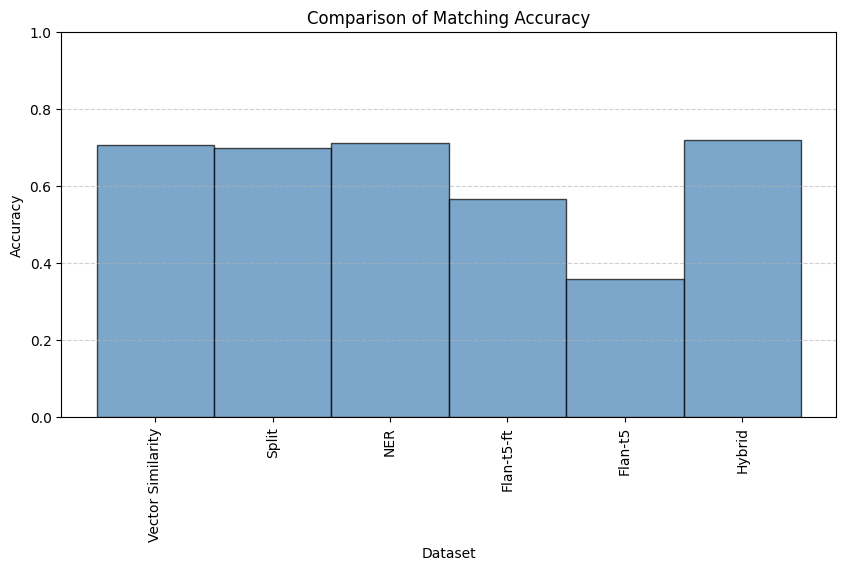

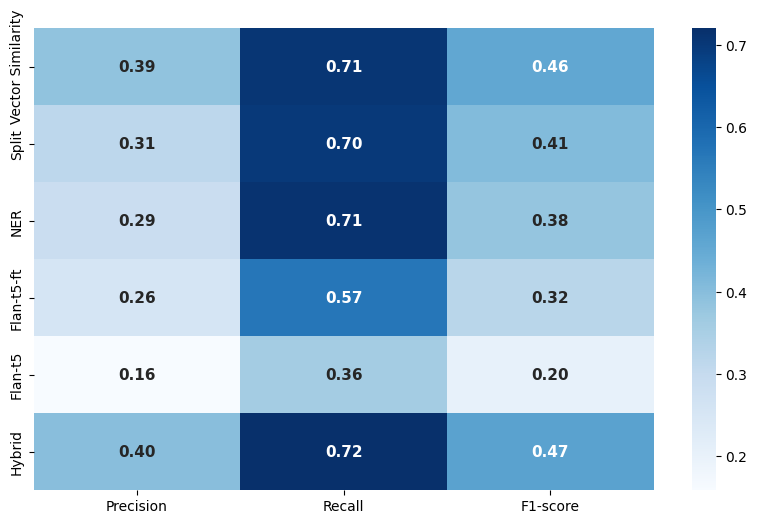

,Precision,Recall,F1-score,Threshold,Skills-count,Matched,Accuracy,Avg-Score
Vector Similarity,0.386778,0.706667,0.456222,0.7,741,212 / 300,0.706667,0.3019
Split,0.314500,0.700000,0.408000,0.7,1135,210 / 300,0.700000,0.3535
NER,0.288222,0.713333,0.382111,0.7,1135,214 / 300,0.713333,0.3205
Flan-t5-ft,0.255833,0.566667,0.321889,0.7,903,170 / 300,0.566667,0.2010
Flan-t5,0.158722,0.360000,0.203000,0.7,898,108 / 300,0.360000,0.1326
Hybrid,0.398444,0.720000,0.468444,0.7,787,216 / 300,0.720000,0.2900


In [30]:
plot_histogram(res_df)
print("")
plot_heatmap(res_df)
print("")
res_df